### 读取文本数据并转换编码

In [1]:
import torch
from io import open
import os
import unicodedata
import string
import torch.nn as nn
import time

" 最后添加的 & 代表eof"
all_letters = string.ascii_letters + ".,:''&"
n_letters = len(all_letters)

def unicode2ascii(s):
    """
    转换unicode编码的字符为纯ascii字符串
    """
    return ''.join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def lines2ascii(file):
    result = []
    for line in file.readlines():
        result.append(unicode2ascii(line).strip())
    return result


def read_data(root):
    """
    读取名字和语言数据为一个字典
    """
    result = {}
    for file_name in os.listdir(root):
        if str(file_name).endswith('.txt'):
            lan = file_name.replace('.txt', '')
            with open(os.path.join(root, file_name), encoding='UTF-8') as file:
                result[lan] = lines2ascii(file)
    return result


train_data = read_data('./data/names')

In [2]:
all_categories = list(train_data.keys())
n_category = len(all_categories)

### 辅助函数

In [3]:
import random

# def char2Vec(c):
#     """
#     映射字符为向量数据，输入为字符，输出为宽度与 all_letters长度相同的向量
#     """
#     vec = torch.zeros(len(all_letters))
#     vec[all_letters.index(c)] = 1
#     return vec
# print(char2Vec('d'))

def get_train_vec(name):
    """
    将字符串转换为vec表示，形状为 len*1*n_letter
    """
    vec = torch.zeros(len(name), 1, len(all_letters))
    for i in range(len(name)):
        vec[i][0][all_letters.index(name[i])] = 1
    return vec

print(get_train_vec('ab'))

def get_target_vec(name):
    """
    将字符串转换为输出部分预测的字符串，即下标向后平移一个单位，直到 eof:&
    为了适用于NLLoss损失函数，这里应该给出一个下标数组
    """
    name += '&'
    name = name[1:]
    size = len(name)
    vec = torch.zeros(size, dtype=torch.long)
    for i in range(size):
        vec[i] = all_letters.index(name[i])
    return vec

print(get_target_vec('ab'))

def get_letter(output):
    """
    获取最高概率的输出并转换为字符串
    """
    top_n, top_i = output.topk(1)
    letter_i = top_i[0].item()
    return all_letters[letter_i], letter_i

def random_chioce(data):
    """
    在列表中随机选择一个条目返回
    """
    return data[random.randint(0, len(data)-1)]

def get_vec_label(lan):
    """
    将标签从语言转换为one hot向量
    """
    vec = torch.zeros(1, n_category)
    vec[0][all_categories.index(lan)] = 1
    
    return vec

def get_train_examples(train_data):
    """
    在训练数据中随机选择1训练条目
    """
   
    lan = random_chioce(all_categories)
    name = random_chioce(train_data[lan])
    lan_vec = get_vec_label(lan)
    name_vec = get_train_vec(name)
    target_vec = get_target_vec(name)
    
    return name_vec, lan_vec, target_vec

print(get_train_examples(train_data))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])
tensor([ 1, 57])
(tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

### RNN

In [4]:
class Rnn(nn.Module):
    def __init__(self, input_size, output_size, category_size, hidden_size):
        """
        定义神经层使用的函数
        """
        super(Rnn, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size + category_size,
                             hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size + category_size,
                             output_size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, in_tensor, category_tensor, hidden_tensor):
        """
        定义神经网络中的数据流处理逻辑
        """
        cat_tensor = torch.cat((in_tensor, hidden_tensor, category_tensor), 1)
        hidden = self.i2h(cat_tensor)
        out_tensor = self.i2o(cat_tensor)
        
        out_tensor = torch.cat((out_tensor, hidden), 1)
        out_tensor = self.o2o(out_tensor)
        
        out_tensor = self.dropout(out_tensor)
        out_tensor = self.softmax(out_tensor)
        return out_tensor, hidden
    
    def init_hidden(self):
        return torch.randn(1, self.hidden_size)

### train step

In [5]:
hidden_size = 1024
rnn = Rnn(n_letters, n_letters, n_category, hidden_size).cuda()
all_losses = []
loss_func = nn.NLLLoss()
lr = 0.0001

def train_one(train_tensor, target_tensor, category_tensor):
    target_tensor.unsqueeze_(-1)
    train_len = train_tensor.size()[0]
    
    rnn.zero_grad()
    hidden = rnn.init_hidden().cuda()
    
    loss = 0
    
    for i in range(train_len):
        out, hidden = rnn(train_tensor[i], category_tensor, hidden)
#         print(out.size(), target_tensor[i].size())
#         print(target_tensor)
        cur_loss = loss_func(out, target_tensor[i])
        loss += cur_loss
    
    loss.backward()
    
    for p in rnn.parameters():
        if p is not None:
            p.data.add_(-lr, p.grad.data)
    return out, loss.item()/train_len
    
    

In [6]:
import time
iters = 200000
print_every = 5000
plot_every = 500

def train_all(train_data):
    start = time.time()
    cur_loss = 0
    
    for i in range(iters):
        name_vec, lan_vec, target_vec = get_train_examples(train_data)
        out, loss = train_one(name_vec.cuda(), target_vec.cuda(), lan_vec.cuda())
        cur_loss += loss
        if i % plot_every == 0:
            all_losses.append(cur_loss/plot_every)
            cur_loss = 0
        
        if i % print_every == 0:
            print(time.time() - start)
            print(cur_loss)

train_all(train_data)

c:\users\lihaiyang\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:27: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)


0.17800211906433105
0
35.942001819610596
0
74.4000015258789
0
113.71000146865845
0
153.22700095176697
0
192.85199999809265
0
232.1130018234253
0
272.7190022468567
0
312.29500102996826
0
351.1000144481659
0
392.28311371803284
0
432.95435905456543
0
473.6520485877991
0
514.2195310592651
0
555.5251679420471
0
596.8450202941895
0
638.6246602535248
0
679.6502861976624
0
720.3351585865021
0
760.5866892337799
0
801.1957011222839
0
840.6600704193115
0
880.6183345317841
0
920.6111855506897
0
961.4472489356995
0
1003.8371586799622
0
1044.5914013385773
0
1085.1370153427124
0
1125.7483615875244
0
1167.2902402877808
0
1208.4079456329346
0
1249.2890679836273
0
1290.689067363739
0
1331.804067850113
0
1372.10906624794
0
1412.386067867279
0
1452.6820666790009
0
1493.138067483902
0
1532.8320655822754
0
1573.466067790985
0


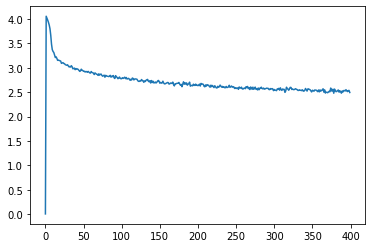

In [7]:
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

### 预测名称

In [15]:
def predict(lan, start):
    """
    预测lan语言下的名字，以start开头
    """
    lan_vec = get_vec_label(lan)
    in_vec = torch.zeros(1,n_letters)
    in_vec[0][all_letters.index(start)] = 1
    hidden = rnn.init_hidden()
    
    name = [start]
    while name[-1] is not '&':
        out, hidden = rnn(in_vec.cuda(), lan_vec.cuda(), hidden.cuda())
        in_vec = out
        letter, _ = get_letter(out)
        name.append(letter)
        print(name)
    
    return name

predict('Chinese', 'z')

['z', 'a']
['z', 'a', 'n']
['z', 'a', 'n', 'a']
['z', 'a', 'n', 'a', 'm']
['z', 'a', 'n', 'a', 'm', 'a']
['z', 'a', 'n', 'a', 'm', 'a', 'n']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n', 'a']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a']
['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a', 'n']
['z', 'a', 'n', 'a', 'm', 'a', 'n', '

['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a', 'n', 'a', 'v', 'a', 'v', 'a', 'n', 'a', 'n', 'e', 'n', 'a', 'n', 'o', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',

['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a', 'n', 'a', 'v', 'a', 'v', 'a', 'n', 'a', 'n', 'e', 'n', 'a', 'n', 'o', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',

['z', 'a', 'n', 'a', 'm', 'a', 'n', 'o', 'r', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a', 'n', 'a', 'v', 'a', 'v', 'a', 'n', 'a', 'n', 'e', 'n', 'a', 'n', 'o', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'a', 'v', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

